In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [4]:
image_path="/kaggle/input/sudurpaschim-famous-tourist-destinations/Sudurpaschim famous destinations/train"

train_path="/kaggle/input/sudurpaschim-famous-tourist-destinations/Sudurpaschim famous destinations/train"
valid_path="/kaggle/input/sudurpaschim-famous-tourist-destinations/Sudurpaschim famous destinations/valid"

In [5]:
# Define the list of class names (folders)
class_names = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))]

In [6]:
number_of_images = {}
for class_name in class_names:
    number_of_images[class_name] = len(os.listdir(image_path+"/"+class_name))

images_per_class = pd.DataFrame(list(number_of_images.items()), columns=['Class Name', 'Number of Images'])
images_per_class

,Class Name,Number of Images
0,Ajaymeru Kot,75
1,Saileshwori Temple,134
2,Ugratara Temple,107
3,Dodhara Chadani Suspension Bridge,75
4,Amargadhi Fort,90
5,Surma Sarover,85
6,GhodaGhodi Taal,96
7,BadiMalika,91
8,Linga,78
9,Bedkot Lake,99


In [7]:
# Training data generator with data augmentation
traindata_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (rescaling only)
validdata_generator = ImageDataGenerator(rescale=1./255)

# Test data generator (rescaling only)
testdata_generator=ImageDataGenerator(rescale=1./255)

In [8]:
# Training data
train_generator = traindata_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation data
validation_generator = validdata_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1348 images belonging to 15 classes.
Found 257 images belonging to 15 classes.


In [9]:
# Load MobileNetV2 with pre-trained weights and exclude the top layers
mobilenetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Freeze the base model
for layer in mobilenetV2_model.layers:
    layer.trainable = False
    
# Add custom layers on top of the base model
x = mobilenetV2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
prediction = Dense(15, activation='softmax')(x)

In [11]:
# Create the final model
model = Model(inputs=mobilenetV2_model.input, outputs=prediction)

In [12]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,104,271 (15.66 MB)

 Trainable params: 1,845,263 (7.04 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [14]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [15]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/43 ━━━━━━━━━━━━━━━━━━━━ 25:23 36s/step - accuracy: 0.0312 - loss: 3.5476

I0000 00:00:1720460341.253654     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720460341.290607     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5803 - loss: 1.4802

W0000 00:00:1720460432.597276     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5872 - loss: 1.4547 - val_accuracy: 0.7899 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9210 - loss: 0.3102 - val_accuracy: 0.8366 - val_loss: 0.5346 - learning_rate: 0.0010
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9396 - loss: 0.1880 - val_accuracy: 0.9339 - val_loss: 0.2169 - learning_rate: 0.0010
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9698 - loss: 0.1135 - val_accuracy: 0.9416 - val_loss: 0.2271 - learning_rate: 0.0010
Epoch 5/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9670 - loss: 0.1072 - val_accuracy: 0.8599 - val_loss: 0.5218 - learning_rate: 0.0010
Epoch 6/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9627 - loss: 0.1036 - val_accuracy: 0.9027 - val_loss: 0.3595 - learning_rate: 0.0010
Epoch 7/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9734 - loss: 0.0880 - val_accuracy: 0.9300 - v

In [16]:
# Unfreeze the base model and fine-tune
for layer in mobilenetV2_model.layers:
    layer.trainable = True

In [17]:
# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
 1/43 ━━━━━━━━━━━━━━━━━━━━ 49:20 70s/step - accuracy: 0.5000 - loss: 1.3371

W0000 00:00:1720461824.499329     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7527 - loss: 0.8050

W0000 00:00:1720461917.486504     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.7539 - loss: 0.8015 - val_accuracy: 0.9494 - val_loss: 0.1715 - learning_rate: 1.0000e-05
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8483 - loss: 0.4944 - val_accuracy: 0.9455 - val_loss: 0.1811 - learning_rate: 1.0000e-05
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8761 - loss: 0.3875 - val_accuracy: 0.9416 - val_loss: 0.1959 - learning_rate: 1.0000e-05
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9114 - loss: 0.2950 - val_accuracy: 0.9455 - val_loss: 0.2133 - learning_rate: 1.0000e-05
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9272 - loss: 0.2416 - val_accuracy: 0.9455 - val_loss: 0.2124 - learning_rate: 2.0000e-06


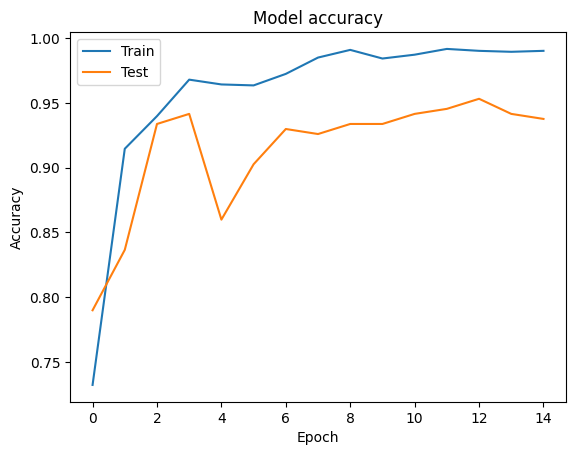

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

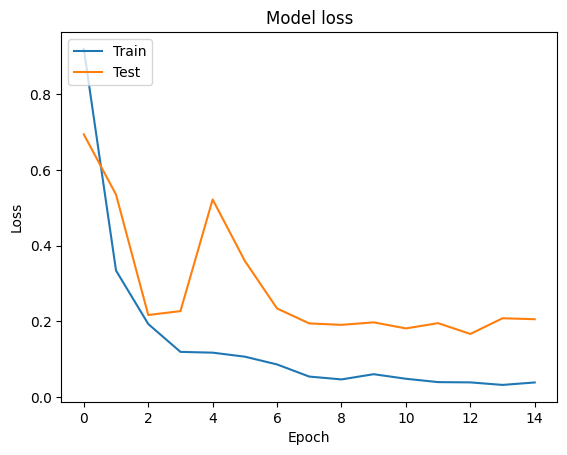

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
model.save('place_recommend_model.h5')